# Project 2: Thermoelectric Generator

## Import and Install Libraries

In [55]:
%%capture
%pip install pandas pyfluids sympy scipy numpy matplotlib openpyxl tqdm

import pandas as pd # This makes nice tables
import pyfluids # This does the thermodynamics
import math
import numpy as np
from scipy.optimize import fsolve, root
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator


In [56]:
from pyfluids import Fluid, FluidsList, Input

water = Fluid(FluidsList.Water)

## Power Requirements

In [57]:
voltage_required = 3.3 # Volts
total_power_draw = 0.7071899999999999 # Watts
current_required = 0.21429999999999996 # Amps
current_required

0.21429999999999996

## Solar Irradiation

In [58]:
# kWh/m^2 per day
min_irradiation = 4.38
max_irradiation = 4.93

min_irradiation *= 1e3 / 12
max_irradiation *= 1e3 / 12 

min_irradiation, max_irradiation

(364.99999999999994, 410.8333333333333)

In [59]:
# Celcius
min_avg_temp = 24
max_avg_temp = 37

zero_celsius = 273.15

## Wind Speed

In [60]:
average_wind_speed = 3 # m/s

## Hourly Constants

In [61]:
# Load the Excel file into a pandas DataFrame
constant_frame = pd.read_excel('Project2Data/Hourly T,v,G.xlsx')
print(constant_frame.columns)

# Now you can work with the DataFrame 'df'
print(constant_frame.head())  # Display the first few rows of the DataFrame?

constant_frame['Hot Temp'] = 0.0
constant_frame['Cold Temp'] = 0.0
constant_frame['Amps'] = 0.0
constant_frame['Voltage'] = 0.0

constant_frame

Index(['Month', 'Day', 'Hour', 'Beam Irradiance (W/m2)',
       'Ambient Temperature (C)', 'Wind Speed (m/s)'],
      dtype='object')
   Month  Day  Hour  Beam Irradiance (W/m2)  Ambient Temperature (C)  \
0      6    1     0                       0                       21   
1      6    1     1                       0                       21   
2      6    1     2                       0                       20   
3      6    1     3                       0                       20   
4      6    1     4                       0                       20   

   Wind Speed (m/s)  
0               0.8  
1               0.8  
2               0.7  
3               0.7  
4               0.7  


,Month,Day,Hour,Beam Irradiance (W/m2),Ambient Temperature (C),Wind Speed (m/s),Hot Temp,Cold Temp,Amps,Voltage
0,6,1,0,0,21,0.8,0.0,0.0,0.0,0.0
1,6,1,1,0,21,0.8,0.0,0.0,0.0,0.0
2,6,1,2,0,20,0.7,0.0,0.0,0.0,0.0
3,6,1,3,0,20,0.7,0.0,0.0,0.0,0.0
4,6,1,4,0,20,0.7,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2923,9,30,19,0,19,1.4,0.0,0.0,0.0,0.0
2924,9,30,20,0,18,1.4,0.0,0.0,0.0,0.0
2925,9,30,21,0,17,1.3,0.0,0.0,0.0,0.0
2926,9,30,22,0,16,1.2,0.0,0.0,0.0,0.0


## Heat Transfer Characteristics

In [62]:
teg_length = 0.03 # m
teg_thickness = 3.75e-3 # m
teg_conductivity = 1.72 # W/mK
teg_alpha = 0.96
teg_eps = 0.12
algae_temp = 30 # C

## Natural Convection for the Bottom of the Plate

In [63]:
def calcBeta(Tc,Tw):
    """
    Calculates Beta coefficient

    Parameters:
    -Tc (float): Temp (K) of the cold side of the thermoelectric generator
    -Th (float): Temp (K) of the hot side of the thermoelectric generator

    Returns:
    -beta (float): coefficient value
    """
    water_Amb = water.with_state(
      Input.pressure(101325), Input.temperature(Tw-273)
    )

    rhoAmb = water_Amb.density

    T = Tc - 273
    rho = (999.83952 + 16.945176 * T - 7.9870401E-3 * (T**2) - 49.170461E-6 * (T**3) + 105.56302E-9 * (T**4) - 280.54253E-12 * (T**5))/(1+16.897850E-3 * T)
    print(rho)

    beta = -1/rho * (rhoAmb-rho)/(Tw-Tc)
    return beta


In [64]:
def calcRalyeighNumber(beta, Tc, Tw, x, alpha):
    """
    Calculates RalyeighNumber

    Parameters:
    -Tc (float): Temp (K) of the cold side of the thermoelectric generator
    -beta (float): coefficient value
    -Tw (float): Temp (K) of the water
    -x (float): Length in meters
    -alpha (float)

    Returns:
    -RaX
    """
    #Find dT
    deltaT = Tc - Tw
    #Define Constants
    g = 9.81
    kinematic_viscosity = 8.005E-7
    #Calculate Ra
    Rax  = abs(g * beta * deltaT * (x)**3 / (kinematic_viscosity * alpha))
    return Rax

In [65]:
def bottomConvection(Tc,Tw,L,alpha):

    Pr = 6.9
    beta = calcBeta(Tc,Tw)
    
    #Calculate Ralyeigh Number at x = L
    RaL = calcRalyeighNumber(beta,Tc, Tw, L, alpha)

    assert RaL > 1e4 and RaL < 1e9, "Ralyeigh Number is out of bounds"
    
    NuL = 0.52 * RaL ** (1/5)

    kf = 0.598E-3 # kW/mK
    ha = NuL * kf / L

    return ha


## Forced Convection on Top of the Plate

In [66]:
def topForcedConvectionCoefficient(u,Lplate):
    """
    Calculates h for the top plate due to wind

    Parameters:
    -u (float): Wind speed (m/s)
    -Lplate (float):Length of solar abosrber (m)

    Returns:
    -ha (float): Convection coefficient (W/m^2 K)
    """
    #Forced Convection on the top of the plate
    #Constants for 
    kf = 0.0259 #W/(mk)
    kinematic_viscosity = 1.61E-5
    Pr = 0.71

    Re_crit = 5e5

    Re = u * Lplate / (kinematic_viscosity)
    
    if Re < Re_crit:
        NuL = 0.664 * Re ** (1/2) * Pr ** (1/3)
    else:
        A = 0.037 * Re_crit ** (4/5) - 0.664 * Re_crit ** (1/2)
        NuL = (0.037 * Re ** (4/5) - A) * Pr ** (1/3)
    ha = NuL * kf / Lplate

    return ha


## TEG

In [67]:
amps = pd.read_csv('Project2Data/Voltage and Current - Amps Verbose.csv')
volts = pd.read_csv('Project2Data/Voltage and Current - Volts Verbose.csv')

volts.describe()

,T cold,T hot,V
count,33.000000,33.000000,33.000000
mean,35.000000,175.000000,2.975152
std,10.968705,80.282704,1.629830
min,25.000000,50.000000,0.000000
25%,25.000000,100.000000,1.650000
50%,30.000000,175.000000,3.200000
75%,50.000000,250.000000,4.350000
max,50.000000,300.000000,5.450000


In [68]:
amps_interp = RegularGridInterpolator((amps['T cold'].unique(), amps['T hot'].unique()),
                                      amps['I'].to_numpy().reshape(
                                        len(amps['T cold'].unique()),
                                        len(amps['T hot'].unique())))
volts_interp = RegularGridInterpolator((volts['T cold'].unique(), volts['T hot'].unique()),
                                      volts['V'].to_numpy().reshape(
                                        len(volts['T cold'].unique()),
                                        len(volts['T hot'].unique())))

## Heat Balance Equations

In [69]:
plate_length = 1 # m

teg_series = 7
teg_parallel = 3

teg_count = teg_series * teg_parallel

In [70]:
def updatedSolution(u, L_plate, T_algae, L, alpha, G, epsilon, Tamb, Kt, N, t, L_sink):
    """
    Numerically solves for Th (Temp (K) of hot side of thermoelectric generator), and Tc (Temp (K) of cold side of thermoelectric generator)

    Parameters:
    -u (float): Wind speed (m/s)
    -L_plate (float):Length of solar abosrber (m)
    -L (float): length of thermoelectric generator module (m)
    -alpha (float):
    -G (float): 
    -epsilon (float): emmisivity 
    -Tamb (float): Ambient Temperature (K)
    -Kt (float): Thermal conductivity of the thermoelectric element
    -N (int): number of modules
    -t (float): Thickness of the thermoelectric element (m)
    -L_sink (float): Length of the heat sink (m)

    
    """    

    def residuals(vars):
        Th, Tc, h_w, rho = vars

        ha = topForcedConvectionCoefficient(u, L_plate)
        stefan = 5.67E-8

        top_plate = G * alpha - stefan * epsilon * Th ** 4 - ha * (Th - Tamb)
        top_plate *= L_plate ** 2
        through_gen = N * L ** 2 * Kt / t * (Th - Tc)
        into_water = h_w * (Tc - T_algae) * L_sink ** 2 

        top_to_gen = top_plate - through_gen
        gen_to_water = through_gen - into_water

        # Calculate rho
        water_Amb = water.with_state(Input.pressure(101325), Input.temperature(T_algae-273))
        rhoAmb = water_Amb.density
        rho_expr = 999.83952 + 16.945176 * (Tc - 273)
        rho_expr -= 7.9870401E-3 * ((Tc - zero_celsius)**2) - 49.170461E-6 * ((Tc - zero_celsius)**3)
        rho_expr += 105.56302E-9 * ((Tc - zero_celsius)**4) - 280.54253E-12 * ((Tc - zero_celsius)**5)
        rho_expr /= 1+16.897850E-3 * (Tc - zero_celsius)
        rho_balance = rho - rho_expr

        Beta = -1/rho * (rhoAmb-rho)/(T_algae - Tc)

        # Calculate RaL
        deltaT = Tc - T_algae
        g = 9.81
        kinematic_viscosity = 8.005E-7
        RaL = abs(g * Beta * deltaT * (L_sink)**3 / (kinematic_viscosity * alpha))

        Pr = 6.9
        NuL = 0.68 + 0.670 * (RaL) ** (1/4) * (1 - (0.492/Pr) ** (9/16)) ** (-4/9)
        
        water_convective_coeff = h_w - NuL * 0.6 / L
        return [top_to_gen, gen_to_water, water_convective_coeff, rho_balance]

    initial_guess = [400, 300, 50, 900]
    s = root(residuals, initial_guess, method = 'lm')

    return s

In [71]:

def hourly_solve(irradiation, ambient_temp, wind_speed):
    sol = updatedSolution(u = wind_speed,
                      L_plate = plate_length,
                      T_algae = algae_temp + zero_celsius,
                      L = teg_length,
                      alpha = teg_alpha,
                      G = irradiation,
                      epsilon = teg_eps,
                      Tamb = ambient_temp + zero_celsius,
                      Kt = teg_conductivity,
                      N = teg_count,
                      t = teg_thickness,
                      L_sink = plate_length)
    if (sol.success):
      hot_temp = sol.x[0] - zero_celsius
      cold_temp = sol.x[1] - zero_celsius
      # print("T_h (˚C):", hot_temp)
      # print("T_c (˚C):", cold_temp)
      # print("delta T:", sol.x[0] - sol.x[1])
      # print("h_w:", sol.x[2])
      # print("rho:", sol.x[3])
      current = 0
      emf = 0

      if hot_temp > amps['T hot'].min() and hot_temp < amps['T hot'].max() and cold_temp > amps['T cold'].min() and cold_temp < amps['T cold'].max():
        try:
          current = amps_interp((cold_temp, hot_temp)) * teg_parallel
          emf = volts_interp((cold_temp, hot_temp)) * teg_series

          # print("Current:", current)
          # print("Voltage:", emf)
        except ValueError:
          print("Temperature out of range for interpolation @ {} C, {} C".format(cold_temp, hot_temp))
      return hot_temp, cold_temp, current, emf
      
  
hourly_solve(min_irradiation, min_avg_temp, average_wind_speed)

(46.03734220611051, 30.599196236122737, 0, 0)

## Hour by Hour Analysis

In [72]:
constant_frame.head()

,Month,Day,Hour,Beam Irradiance (W/m2),Ambient Temperature (C),Wind Speed (m/s),Hot Temp,Cold Temp,Amps,Voltage
0,6,1,0,0,21,0.8,0.0,0.0,0.0,0.0
1,6,1,1,0,21,0.8,0.0,0.0,0.0,0.0
2,6,1,2,0,20,0.7,0.0,0.0,0.0,0.0
3,6,1,3,0,20,0.7,0.0,0.0,0.0,0.0
4,6,1,4,0,20,0.7,0.0,0.0,0.0,0.0


In [73]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

def solve(ind, row):
  return ind, hourly_solve(row['Beam Irradiance (W/m2)'], row['Ambient Temperature (C)'], row['Wind Speed (m/s)'])

with ThreadPoolExecutor() as executor:
  futures = [executor.submit(solve, ind, row) for ind, row in constant_frame.iterrows()]
  for future in tqdm(futures, total=len(constant_frame)):
    ind, result = future.result()
    constant_frame.at[ind, 'Hot Temp'] = result[0]
    constant_frame.at[ind, 'Cold Temp'] = result[1]
    constant_frame.at[ind, 'Amps'] = result[2]
    constant_frame.at[ind, 'Voltage'] = result[3]


100%|██████████| 2928/2928 [00:45<00:00, 64.99it/s] 


In [76]:
constant_frame.describe()

,Month,Day,Hour,Beam Irradiance (W/m2),Ambient Temperature (C),Wind Speed (m/s),Hot Temp,Cold Temp,Amps,Voltage
count,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000
mean,7.500000,15.754098,11.500000,248.615096,27.927937,2.572985,42.916493,33.556756,0.170266,1.647702
std,1.110868,8.808461,6.923369,320.382517,5.117539,1.230646,22.412198,5.329979,0.265217,2.584565
min,6.000000,1.000000,0.000000,0.000000,14.000000,0.300000,22.700168,12.654361,0.000000,0.000000
25%,7.000000,8.000000,5.750000,0.000000,24.000000,1.600000,25.748552,29.854631,0.000000,0.000000
50%,7.500000,16.000000,11.500000,10.500000,27.000000,2.500000,28.413087,31.763360,0.000000,0.000000
75%,8.000000,23.000000,17.250000,524.000000,32.000000,3.400000,59.796741,32.646684,0.403290,3.772865
max,9.000000,31.000000,23.000000,971.000000,41.000000,8.100000,100.658191,53.361726,0.979276,9.379609


<Axes: title={'center': 'Current and Voltage vs. Hour'}, xlabel='Hour'>

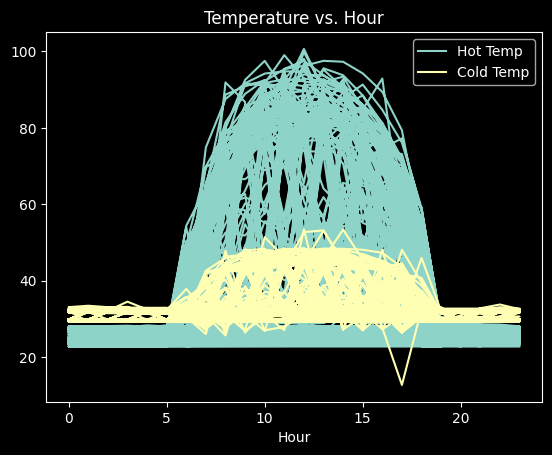

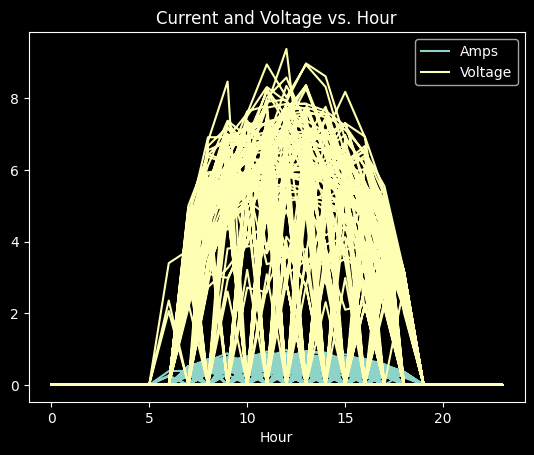

In [78]:
constant_frame.plot(x='Hour', y=['Hot Temp', 'Cold Temp'], kind='line', title='Temperature vs. Hour', style='-')
constant_frame.plot(x='Hour', y=['Amps', 'Voltage'], kind='line', title='Current and Voltage vs. Hour', style='-')
